TASK 1

In [109]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
import tensorflow as tf  
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd


132 33
792 792


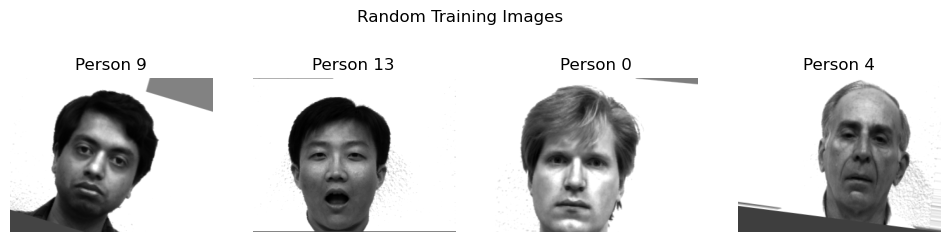

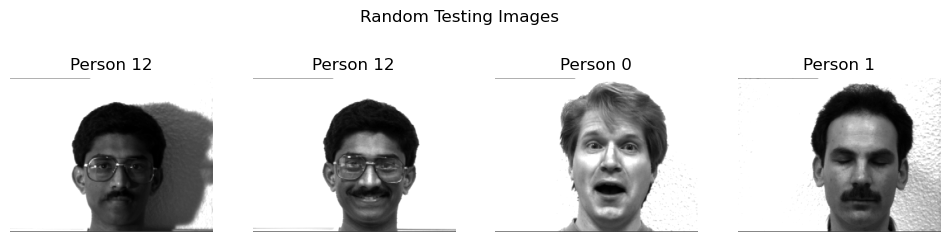

In [110]:


# Load and preprocess the data
data = []  # List to store image data
labels = []  # List to store labels

# Define a function to extract the person label from the file name
def extract_person_label(file_name):
    return int(file_name.split('.')[0].replace('subject', '')) - 1  # Subtract 1 to make labels start from 0

# Load data and labels
# Assuming the dataset files are in the 'dataset' directory
dataset_dir = 'E:/Desktop/DL_codes/yale'

for file_name in os.listdir(dataset_dir):
        img = plt.imread(os.path.join(dataset_dir, file_name))
        # Ensure that the image is in shape (height, width, 1) for grayscale
        img = img[:, :, np.newaxis]
        data.append(img / 255.0)
        labels.append(extract_person_label(file_name))

data = np.array(data)
#data = data.reshape((-1, 243, 320, 1)
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(len(X_train), len(X_test))

# Function to perform data augmentation
def augment_data(images, labels, num_augmented_samples=5):
    augmented_images = []
    augmented_labels = []
    
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    for i in range(num_augmented_samples):
        for j, (image, label) in enumerate(zip(images, labels)):
            augmented_image = datagen.random_transform(image)
            augmented_images.append(augmented_image)
            augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)

# Perform data augmentation on the training set
X_train_augmented, y_train_augmented = augment_data(X_train, y_train, num_augmented_samples=5)

# Concatenate the augmented data with the original training data
X_train_final = np.concatenate((X_train, X_train_augmented), axis=0)
y_train_final = np.concatenate((y_train, y_train_augmented), axis=0)

print(len(X_train_final), len(y_train_final))

import random

# Randomly select four indices from the training dataset
train_indices = random.sample(range(len(X_train_final)), 4)

# Randomly select four indices from the testing dataset
test_indices = random.sample(range(len(X_test)), 4)

# Function to display images
def display_images(images, labels, title):
    plt.figure(figsize=(12, 3))
    plt.suptitle(title)
    for i, (image, label) in enumerate(zip(images, labels), 1):
        plt.subplot(1, 4, i)
        plt.imshow(image.reshape((243, 320)), cmap='gray')
        plt.title(f"Person {label}")
        plt.axis('off')
    plt.show()

# Display four random training images
train_images_to_display = X_train_final[train_indices]
train_labels_to_display = y_train_final[train_indices]
display_images(train_images_to_display, train_labels_to_display, "Random Training Images")

# Display four random testing images
test_images_to_display = X_test[test_indices]
test_labels_to_display = y_test[test_indices]
display_images(test_images_to_display, test_labels_to_display, "Random Testing Images")


In [131]:
#MLP model


class MLPModel:

    def __init__(self, input_size, hidden_units, output_size, activations='sigmoid', learning_rate=0.01, epochs=100, momentum=0.9, lr_decay_epoch=20, lr_decay_factor=0.5):
        self.input_size = input_size
        self.hidden_units = hidden_units
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.momentum = momentum
        self.lr_decay_epoch = lr_decay_epoch
        self.lr_decay_factor = lr_decay_factor          
        self.activations = activations
        

        #accuracies
        self.train_accuracies = []
        self.val_accuracies = []

        # Initialization for hidden + output layer
        self.weights = []
        self.biases = []

        # Number of neurons in all layers [input_size, hidden_units, output_size]
        layer_sizes = [input_size] + hidden_units + [output_size]
        #print(layer_sizes)

        # He Initialization
        for i in range(1, len(layer_sizes)):        
            fan_in = layer_sizes[i - 1]
            fan_out = layer_sizes[i]
            # Use He initialization for weights
            w = np.random.normal(loc=0, scale=np.sqrt(2 / fan_in), size=(fan_in, fan_out))
            # Initialize biases with zeros
            b = np.zeros((1, fan_out))
            self.weights.append(w)
            self.biases.append(b)


            
    # Activation functions
    def _sigmoid(self, x):
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def _relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)
    
    def _tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def _leaky_relu(self, x, alpha=0.01):
        return np.where(x > 0, x, alpha * x)

    def leaky_relu_derivative(self, x, alpha=0.01):
        return np.where(x > 0, 1, alpha)

    def _softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def softmax_derivative(self, x):
        softmax_output = self._softmax(x)
        return softmax_output * (1 - softmax_output)

    # Forward pass
    def _forward(self, x):
        activations_list = [x.reshape(-1, self.input_size)]  # Reshape input to (batch_size, input_size)

        for i in range(len(self.weights)): 
            z = np.dot(activations_list[-1], self.weights[i]) + self.biases[i]

            if i == len(self.weights)-1:
                a = self._softmax(z)
                
            elif self.activations == 'sigmoid':  
                a = self._sigmoid(z)
                                 
            elif self.activations == 'relu':
                a = self._relu(z)
  
            elif self.activations == 'tanh':
                a = self._tanh(z)
                
            elif self.activations == 'leaky_relu':
                a = self._leaky_relu(z) 
  
            else:
                raise ValueError("Unsupported activation function")
            activations_list.append(a)

        return activations_list
    
        # Loss function
    def cross_entropy_loss(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

        # Ensure y_true is a 2D array of one-hot encoded labels
        if y_true.ndim != 2:
            raise ValueError("y_true should be a 2D array of one-hot encoded labels.")

        # Compute the cross-entropy loss
        loss = -np.sum(y_true * np.log(y_pred + epsilon)) / len(y_true)

        return loss

    # Backward pass
    def _backward(self, x, y, activations):
        m = x.shape[0]
        deltas = [None] * len(self.weights)
        
       
    
        loss_gradients = self.cross_entropy_loss(activations[-1], y)
    
        for i in range(len(self.weights) - 1, -1, -1):
            print(i)
            print(self.weights[i].shape)
            
            if i == len(self.weights) - 1:  # Softmax layery
                print('in softmax')
                deltas[i] = loss_gradients
            else:
                if self.activations == 'sigmoid':
                    deltas[i] = np.dot(deltas[i + 1], self.weights[i + 1].T) * self.sigmoid_derivative(activations[i + 1])
                elif self.activations == 'relu':
                    print('in relu')
                    deltas[i] = np.dot(deltas[i + 1], self.weights[i + 1].T) * self.relu_derivative(activations[i + 1])
                elif self.activations == 'leaky_relu':
                    deltas[i] = np.dot(deltas[i + 1], self.weights[i + 1].T) * self.leaky_relu_derivative(activations[i + 1])
                elif self.activations == 'tanh':
                    deltas[i] = np.dot(deltas[i + 1], self.weights[i + 1].T) * self.tanh_derivative(activations[i + 1])
                else:
                    raise ValueError("Unsupported activation function")
                    
                print(f"deltas[{i}] shape: {deltas[i].shape}")
                print(f"self.weights[{i}].T shape: {self.weights[i].T.shape}")

        # Ensure deltas have the same shape as activations for each layer
        for i in range(len(self.weights) - 1):
            if deltas[i].shape != activations[i].shape:
                raise ValueError(f"Shape mismatch in deltas at layer {i} during backpropagation.")

        return deltas
    

    
    
    # Training function
    def fit(self, x_train, y_train, x_val, y_val, batch_size):
        weight_momentums = [np.zeros_like(w) for w in self.weights]
        bias_momentums = [np.zeros_like(b) for b in self.biases]
        current_learning_rate = self.learning_rate

        for epoch in range(self.epochs):
            total_loss = 0

            if epoch % self.lr_decay_epoch == 0 and epoch > 0:
                current_learning_rate *= self.lr_decay_factor

            # Shuffling
            indices = np.arange(len(x_train))
            np.random.shuffle(indices)
            
            weight_gradients = [np.zeros_like(w) for w in self.weights]
            bias_gradients = [np.zeros_like(b) for b in self.biases]


            for i in range(0, len(x_train), batch_size):
                batch_indices = indices[i:i + batch_size]
                batch_x = x_train[batch_indices]
                batch_y = y_train[batch_indices]

                # Forward pass for the entire batch
                activations = self._forward(batch_x)
                

                y_one_hot = np.zeros((batch_y.shape[0], self.output_size))
                y_one_hot[np.arange(batch_y.shape[0]), batch_y] = 1
               

                # Compute loss for the entire batch              
                loss = np.mean(self.cross_entropy_loss(y_one_hot, activations[-1]))
                total_loss += loss

                
                # Backward pass for the entire batch
                deltas = self._backward(batch_x, y_one_hot, activations)

                # Compute gradients for weights and biases
                for k in range(len(self.weights)):
                    weight_gradients[k] = np.dot(activations[k].T, deltas[k])
                    bias_gradients[k] = np.sum(deltas[k], axis=0, keepdims=True)

                for k in range(len(self.weights)):
                    weight_momentums[k] = self.momentum * weight_momentums[k] + weight_gradients[k]
                    bias_momentums[k] = self.momentum * bias_momentums[k] + bias_gradients[k]

                # Update weights and biases using gradient descent
                max_gradient_norm = 1.0
                for k in range(len(self.weights)):
                    gradient = weight_gradients[k] / len(batch_x)
                    if np.linalg.norm(gradient) > max_gradient_norm:
                        gradient *= max_gradient_norm / np.linalg.norm(gradient)
                    self.weights[k] -= current_learning_rate * gradient
                    self.biases[k] -= current_learning_rate * (bias_momentums[k] / len(batch_x))

            
            # Print loss for monitoring training progress
            if epoch % 10 == 0:
                x = epoch + 10
                print(f"Epoch {x}/{self.epochs}, Loss: {total_loss / len(x_train):.4f}")

            train_acc = accuracy_score(y_train, self.predict(x_train))
            val_acc = accuracy_score(y_val, self.predict(x_val))
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

        print("Training complete")
        
    def predict(self, x):
        predictions = []
        
        for i in range(len(x)):
            # Forward pass
            activations = self._forward(x[i])
            
            # output activations contain the predictions
            prediction = np.argmax(activations[-1])  
            predictions.append(prediction)
        return np.array(predictions)
    
    def test(self, x_test, y_test):
        predictions = self.predict(x_test)
        
        accuracy = accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions, average='weighted')
        recall = recall_score(y_test, predictions, average='weighted')
        f1 = f1_score(y_test, predictions, average='weighted')
        
        metrics = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        }
        
        return metrics
    '''

    def tune(self,X_train, y_train, X_val, y_val):
        param_grid = {
        'hidden_layers': [1, 2, 3],  # Example: Vary the number of hidden layers
        'hidden_units': [(64, 32), (64, 64, 32), (64, 128, 64, 32)],  # Example: Vary the units in hidden layers
        'learning_rate': [0.01, 0.001, 0.0001],  # Example: Vary the learning rate
        'epochs': [50, 100, 200],

        }
        
        best_params = None
        best_model = None
        best_accuracy = 0.0
        
        print("I'm being tuned1")
        
        mlp_classifier = MLPClassifier()
        
        grid_search = GridSearchCV(mlp_classifier, param_grid, scoring='accuracy', cv=2, verbose=2, n_jobs=-1)

        grid_search.fit(X_train, y_train)
        
        print("I'm being tuned2")
        
        best_params = grid_search.best_params_
        
        best_model = grid_search.best_estimator_

        return best_params, best_model
        
    
            '''

In [112]:
def plot_accuracies(train_accuracies, val_accuracies):
    epochs = range(1, len(train_accuracies) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
    plt.title('Train and Validation Accuracies vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [136]:
#dividing training data into training and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train_final, y_train_final, test_size=0.2, random_state=42)

#Before tuning
input_size = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]
#input_size = 243 * 320 * 1
hidden_units = [128, 64]   #length of this determines hidden layers
activations = 'relu'
learning_rate = 0.01 
epochs = 50  
output_size=15
batch_size = 32



model = MLPModel(input_size, hidden_units, output_size, activations, learning_rate, epochs)

# Train the model on the training data

print("Before tuning: Experiment 1")

model.fit(X_train, y_train, X_val, y_val, batch_size)

plot_accuracies(model.train_accuracies, model.val_accuracies)

# Evaluate the model on the test data
metrics = model.test(X_test, y_test)
print("Metrics for Test Data:")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)


confusion_matrix_no_tuning = confusion_matrix(y_test, model.predict(X_test))
print("Confusion Matrix")
print(confusion_matrix_no_tuning)



# Confusion Matrix DataFrame
confusion_df = pd.DataFrame(confusion, index=class_names, columns=class_names)
print("\nConfusion Matrix:")
print(confusion_df)








Before tuning: Experiment 1
2
(64, 15)
in softmax
1
(128, 64)
in relu


ValueError: operands could not be broadcast together with shapes (15,64) (32,64) 

In [84]:
# Check input and output size
print("Shape of X_train:", X_train.shape)

assert input_size == X_train.shape[1], "Input size does not match the shape of X_train"
assert output_size == np.max(y_train) + 1, "Output size does not match the number of unique labels"

# Check batch size compatibility
assert len(X_train) % batch_size == 0, "Batch size is not compatible with the training dataset size"
assert len(X_val) % batch_size == 0, "Batch size is not compatible with the validation dataset size"

# Check hidden units architecture
assert len(hidden_units) > 0, "No hidden layers specified"
assert input_size == X_train.shape[1], "First hidden layer size does not match the input size"
assert output_size == hidden_units[-1], "Last hidden layer size does not match the output size"



Shape of X_train: (1161, 243, 320, 1)


AssertionError: Input size does not match the shape of X_train

In [18]:

class CustomMLPClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, input_size, hidden_units, output_size, activations ='sigmoid', learning_rate=0.01, epochs=100, momentum=0.9, lr_decay_epoch=20, lr_decay_factor=0.5):
        self.input_size = input_size
        self.hidden_units = hidden_units
        self.output_size = output_size
        self.activations = activations
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.momentum = momentum
        self.lr_decay_epoch = lr_decay_epoch
        self.lr_decay_factor = lr_decay_factor
        self.model = None

    def fit(self, X, y):
        self.model = MLPModel(
            input_size=self.input_size,
            hidden_units=self.hidden_units,
            output_size=self.output_size,
            activations=self.activations,
            learning_rate=self.learning_rate,
            epochs=self.epochs,
            momentum=self.momentum,
            lr_decay_epoch=self.lr_decay_epoch,
            lr_decay_factor=self.lr_decay_factor
        )
        self.model.fit(X, y, X, y, batch_size=32)  # Using the same data for training and validation

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

# Define the hyperparameter grid
param_grid = {
    'hidden_units': [[64, 32], [64, 64, 32], [64, 128, 64, 32]],
    'learning_rate': [0.01, 0.001],
    'activations': ['sigmoid','relu'],
    'epochs': [100, 200],
    'momentum': [0.9, 0.95],
}

input_size = 243 * 320  
hidden_units = [128, 64]  
output_size=15

mlp_classifier = CustomMLPClassifier(input_size, hidden_units, output_size)

grid_search = GridSearchCV(mlp_classifier, param_grid, scoring='accuracy', cv=2, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Hyperparameters:")
print(grid_search.best_params_)
print("Best Validation Accuracy:", grid_search.best_score_)

best_model = grid_search.best_estimator_

test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy for Best Model:", test_accuracy)






Fitting 2 folds for each of 48 candidates, totalling 96 fits


E:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


KeyboardInterrupt: 

In [21]:
print(best_params)

{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (64, 128, 64), 'learning_rate_init': 0.001, 'max_iter': 400, 'solver': 'adam'}


In [6]:
pip install keras

TASK 2

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical

Epoch 1/20
16/16 [==============================] - 4s 164ms/step - loss: 37.7210 - accuracy: 0.0791 - val_loss: 23.2864 - val_accuracy: 0.0866
Epoch 2/20
16/16 [==============================] - 2s 128ms/step - loss: 11.1930 - accuracy: 0.1146 - val_loss: 6.2687 - val_accuracy: 0.1260
Epoch 3/20
16/16 [==============================] - 2s 127ms/step - loss: 4.3006 - accuracy: 0.1403 - val_loss: 3.6346 - val_accuracy: 0.1575
Epoch 4/20
16/16 [==============================] - 2s 128ms/step - loss: 3.0486 - accuracy: 0.1917 - val_loss: 3.2849 - val_accuracy: 0.0866
Epoch 5/20
16/16 [==============================] - 2s 125ms/step - loss: 2.6413 - accuracy: 0.2194 - val_loss: 2.4113 - val_accuracy: 0.2126
Epoch 6/20
16/16 [==============================] - 2s 131ms/step - loss: 2.3691 - accuracy: 0.2273 - val_loss: 2.3175 - val_accuracy: 0.2598
Epoch 7/20
16/16 [==============================] - 2s 143ms/step - loss: 2.2962 - accuracy: 0.2787 - val_loss: 3.1239 - val_accuracy: 0.1181
Epo

E:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


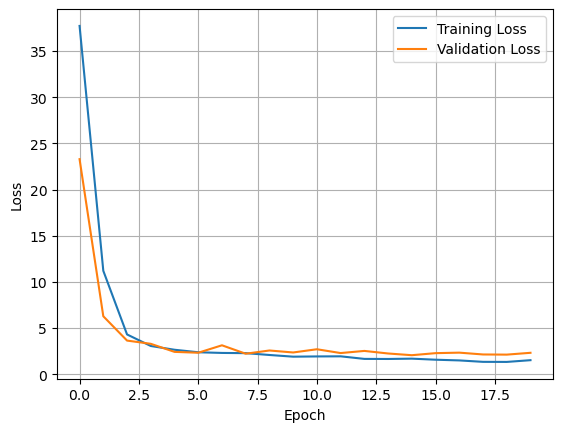

In [134]:

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(243, 320, 1)),  # Specify the input shape
    tf.keras.layers.Flatten(),  # Flatten the input
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(15, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Test the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy, precision, recall, and f1-score
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='macro')
recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')
confusion = confusion_matrix(y_test, y_pred_classes)

# Get unique classes from y_test
unique_classes = np.unique(np.concatenate((y_test, y_pred_classes), axis=None))

# Convert unique classes to strings and create class_names
class_names = [str(c) for c in unique_classes]

metrics_data = {
    'Metric': ['Accuracy', 'Precision (Macro-Average)', 'Recall (Macro-Average)', 'F1-Score (Macro-Average)'],
    'Value': [accuracy, precision, recall, f1]
}

metrics_df = pd.DataFrame(metrics_data)


# Confusion Matrix DataFrame
confusion_df = pd.DataFrame(confusion, index=class_names, columns=class_names)
print("\nConfusion Matrix:")
print(confusion_df)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [135]:
# Display the table
print("Metrics Table:")
print(metrics_df)

Metrics Table:
                      Metric     Value
0                   Accuracy  0.666667
1  Precision (Macro-Average)  0.680952
2     Recall (Macro-Average)  0.678571
3   F1-Score (Macro-Average)  0.637415
